# Stroke Project

In [10]:
### Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import sklearn
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix

The data I am working with for this project is a free healthcare data set provided by kaggle (https://www.kaggle.com/fedesoriano/stroke-prediction-dataset). The goal of this project is to investigate patient data and determine how certain health attributes may play a role in suffering from a stroke. 

In [11]:
### Load in Data
df = pd.read_csv('E:\Documents\GitHub\Python_Practice\Stroke Project\healthcare-dataset-stroke-data.csv')
df = df.dropna()
### Preview of the data set
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [20]:
df['gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

In [3]:
### Total number of patients
print('Number of patients in the data set: {}'.format(len(df)))

Number of patients in the data set: 4909


Right off the bat, we can see that there are a variety of variables (11 total) that include both discrete and continuous values. On top of this, there are also NaN values which I have to dealt with by dropping order to smoothly transtition to the model fitting portion of this project.

But first let us look at some summary statistics and visualizations within the data to get a better understanding of our sample population.

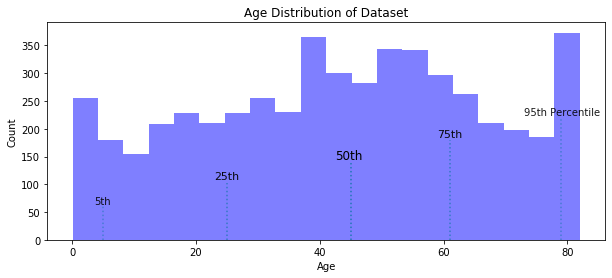

In [23]:
### Isolate Age Data
age_df = df['age']
### Histogram of age Distribution
fig, ax = plt.subplots(figsize = (10,4))
num_bins = 20
n, bins, patches = plt.hist(age_df, num_bins, facecolor='blue', alpha=0.5)
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.set_title("Age Distribution of Dataset")

#Calculate percentiles

quant_5, quant_25, quant_50, quant_75, quant_95 = age_df.quantile(0.05), age_df.quantile(0.25), age_df.quantile(0.5), age_df.quantile(0.75), age_df.quantile(0.95)

# [quantile, opacity, length]
quants = [[quant_5, 0.6, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]

for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")

#Quantile Labels
ax.text(quant_5-1.5, 65, "5th", size = 10, alpha = 0.9)
ax.text(quant_25-2, 110, "25th", size = 11, alpha = 0.95)
ax.text(quant_50-2.5, 145, "50th", size = 12, alpha = 1)
ax.text(quant_75-2, 185, "75th", size = 11, alpha = 0.95)
ax.text(quant_95-6, 225, "95th Percentile", size = 10, alpha =.9)    
    
    
plt.show()

In [24]:
age_df.describe()

count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64

Here we can see that the average patient is in their forties with the mean age being 43 and a median value of 45. Our oldest patient in the data set is 82 while the youngest is less than a year yold (represented by 0.08)

In [25]:
gender = df['gender']
print("Gender Distribution (raw numbers):")
gender.value_counts()

Gender Distribution (raw numbers):


Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [26]:
print("Gender Distribution (relative values):")
gender.value_counts(normalize=True)

Gender Distribution (relative values):


Female    0.585910
Male      0.413894
Other     0.000196
Name: gender, dtype: float64

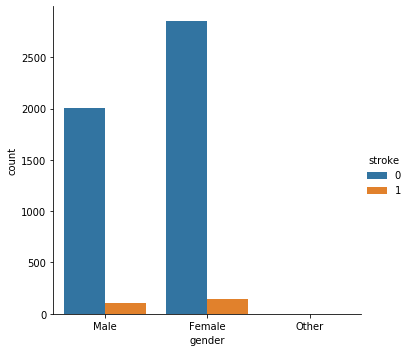

In [28]:
sns.catplot(x='gender', hue='stroke', kind='count', data=df)

In [35]:
strokeGroup = df[df["stroke"] == 0]
bar1 = strokeGroup['age']
nonStrokeGroup = df[df["stroke"] == 1]
bar2 = nonStrokeGroup['age']

bars = np.add(bar1, bar2).tolist()

ValueError: operands could not be broadcast together with shapes (4861,) (249,) 

In [48]:
bins = np.arange(1, 10) * 10
df['category'] = np.digitize(df.age, bins, right=True)
print(bins)

[10 20 30 40 50 60 70 80 90]


In [46]:
counts = df.groupby(['category', 'stroke']).age.count().unstack()

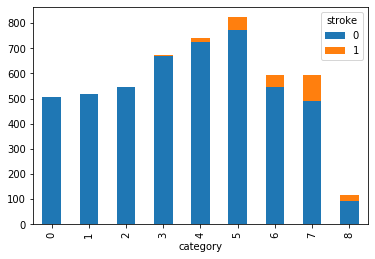

In [47]:
counts.plot(kind='bar', stacked=True)

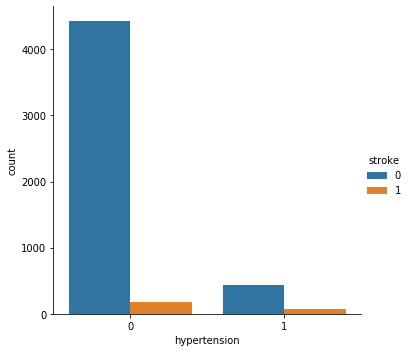

In [49]:
sns.catplot(x='hypertension', hue='stroke', kind='count', data=df)

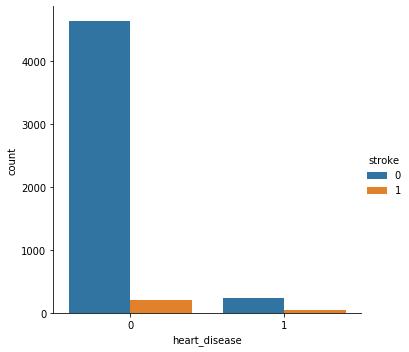

In [50]:
sns.catplot(x='heart_disease', hue='stroke', kind='count', data=df)

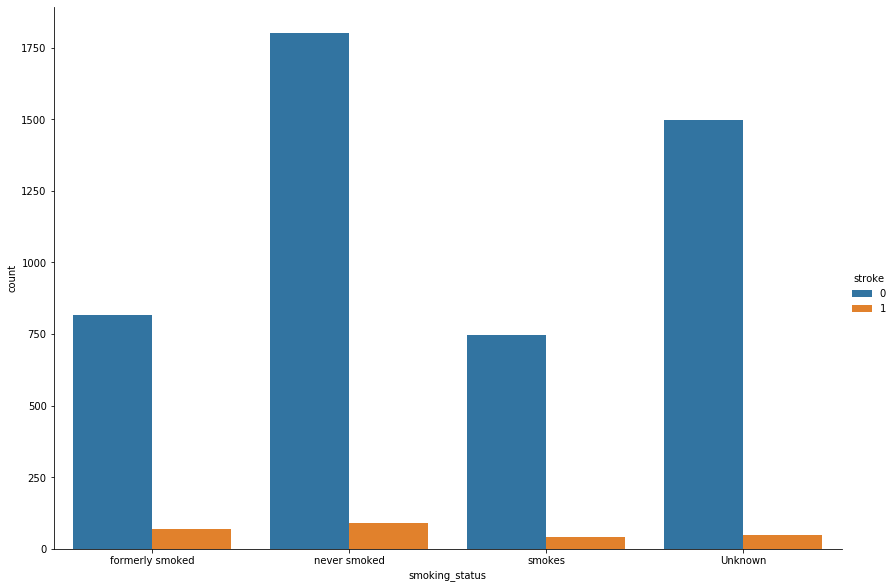

In [52]:
sns.catplot(x='smoking_status', hue='stroke', kind='count', data=df, height=8.27, aspect=11.7/8.27)

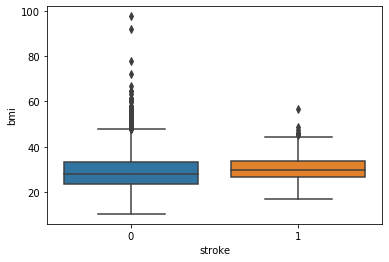

In [11]:
sns.boxplot(x="stroke", y="bmi", data=df)

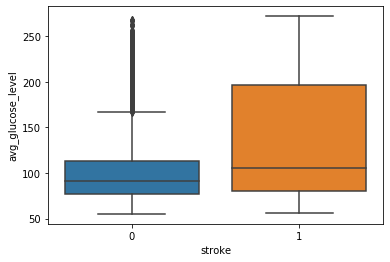

In [15]:
sns.boxplot(x="stroke", y="avg_glucose_level", data=df)

In [4]:
def SmokerClass(CLASS):
    if CLASS == "formerly smoked":
        return 1
    elif CLASS == "never smoked":
        return 2
    elif CLASS == "smokes":
        return 3
    elif CLASS == "Unknown":
        return 4
    
def residenceClass(CLASS):
    if CLASS == "Urban":
        return 1
    elif CLASS == "Rural":
        return 2

df['smoking_status_num'] = df['smoking_status'].apply(SmokerClass)
df['Residence_type_num'] = df['Residence_type'].apply(residenceClass)

In [5]:
##X = df.drop(['stroke', 'smoking_status', 'Residence_type', 'Residence_type_num', 'ever_married', 'work_type', 'gender'], axis=1)
X = df[['age', 'bmi', 'hypertension', 'heart_disease', 'smoking_status_num']]
y = df['stroke']

print(list(X.columns.values)) 
###print(df['Residence_type_num'])

['age', 'bmi', 'hypertension', 'heart_disease', 'smoking_status_num']


In [6]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.20, random_state = 5)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3927, 5)
(982, 5)
(3927,)
(982,)


In [7]:
model = LogisticRegression(random_state=0, multi_class='multinomial', penalty='none', solver='newton-cg').fit(X_train, y_train)
preds = model.predict(X_test)

In [8]:
params = model.get_params()
print(params)

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': None, 'penalty': 'none', 'random_state': 0, 'solver': 'newton-cg', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [9]:
print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)

Intercept: 
 [-4.03744648]
Coefficients: 
 [[0.0357593  0.0110521  0.29577406 0.23098135 0.01360595]]


In [14]:
logit_model=sm.MNLogit(y_train,sm.add_constant(X_train))
logit_model
result=logit_model.fit()
stats1=result.summary()
stats2=result.summary2()
print(stats1)
print(stats2)

Optimization terminated successfully.
         Current function value: 0.142692
         Iterations 9
                          MNLogit Regression Results                          
Dep. Variable:                 stroke   No. Observations:                 3927
Model:                        MNLogit   Df Residuals:                     3924
Method:                           MLE   Df Model:                            2
Date:                Wed, 24 Feb 2021   Pseudo R-squ.:                  0.1887
Time:                        13:26:30   Log-Likelihood:                -560.35
converged:                       True   LL-Null:                       -690.72
Covariance Type:            nonrobust   LLR p-value:                 2.400e-57
  stroke=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.2689      0.612    -13.512      0.000      -9.468      -7.069
age            0.0768      0.

C:\Users\jdblu\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [15]:
confusion_matrix(y_test, preds)

array([[940,   0],
       [ 42,   0]], dtype=int64)

In [19]:
confmtrx = np.array(confusion_matrix(y_test, preds))
pd.DataFrame(confmtrx, index=['No Stroke','Stroke'],
columns=['predicted_no_stroke', 'predicted_stroke'])

,predicted_no_stroke,predicted_stroke
No Stroke,940,0
Stroke,42,0


In [18]:
print('Accuracy Score:', metrics.accuracy_score(y_test, preds))  
class_report=classification_report(y_test, preds)
print(class_report)

Accuracy Score: 0.9572301425661914
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       940
           1       0.00      0.00      0.00        42

    accuracy                           0.96       982
   macro avg       0.48      0.50      0.49       982
weighted avg       0.92      0.96      0.94       982



C:\Users\jdblu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
